## Listing 5.1 The Ad Campaign Environment

In [313]:
import numpy as np

class AdCampaignEnvironment:
    """
    Simulates a multi-armed bandit environment for an ad campaign.

    This class represents the "world" our agent will interact with. It holds the
    secret, true click-through rates (CTRs) for a number of ads (the "arms").
    The agent can't see these probabilities; it can only choose an arm to pull
    and observe the resulting reward.
    """
    def __init__(self, ad_probabilities):
        """
        Initializes the environment.

        Args:
            ad_probabilities (list of floats): A list containing the true CTR
                                                for each ad. Each value should be
                                                between 0 and 1.
        """
        self.ad_probabilities = ad_probabilities
        self.num_ads = len(ad_probabilities)

    def pull_arm(self, ad_index):
        """
        Simulates showing an ad to a user and observing if they click.

        This is the core interaction method. The agent calls this function
        to take an action.

        Args:
            ad_index (int): The index of the ad (arm) to show (pull).

        Returns:
            int: A reward of 1 if the ad is "clicked", 0 otherwise.
        """
        # Ensure the chosen ad index is valid
        if ad_index < 0 or ad_index >= self.num_ads:
            raise ValueError("Invalid ad index.")

        # Get the true CTR for the chosen ad
        ctr = self.ad_probabilities[ad_index]

        # Simulate a click using the CTR.
        # np.random.rand() returns a random float between 0.0 and 1.0.
        # If this random number is less than the ad's CTR, we count it as a click.
        if np.random.rand() < ctr:
            return 1  # A click!
        else:
            return 0  # No click.

## Listing 5.2 The Random Agent

In [314]:
class RandomAgent:
    """
    A baseline agent that always chooses an action randomly.
    It does not learn from its interactions.
    """
    def __init__(self, num_ads):
        self.num_ads = num_ads
        # We still track counts for analysis, but the agent doesn't use them.
        self.arm_counts = [0] * num_ads

    def choose_action(self):
        # Always explore: pick a random integer from 0 to num_ads-1.
        return np.random.randint(self.num_ads)

    def update(self, chosen_ad_index, reward):
        # This agent doesn't learn, but we'll update the counts anyway
        # so we can see which ads it chose.
        self.arm_counts[chosen_ad_index] += 1
        pass # No learning happens here.

## Listing 5.3 The Greedy Agent

In [315]:
class GreedyAgent:
    """
    An agent that always exploits the best-known option.
    It does not have a formal exploration mechanism.
    """
    def __init__(self, num_ads):
        self.num_ads = num_ads
        self.arm_counts = [0] * num_ads
        self.q_values = [0.0] * num_ads

    def choose_action(self):
        # First, check if there's any arm we haven't tried yet.
        # This is our 'cold start' solution.
        for i in range(self.num_ads):
            if self.arm_counts[i] == 0:
                return i

        # If we've tried all arms at least once, be greedy.
        return np.argmax(self.q_values)

    def update(self, chosen_ad_index, reward):
        self.arm_counts[chosen_ad_index] += 1
        n = self.arm_counts[chosen_ad_index]
        current_q = self.q_values[chosen_ad_index]
        # Same incremental update formula as we'll see in other agents.
        new_q = current_q + (1/n) * (reward - current_q)
        self.q_values[chosen_ad_index] = new_q

## Listing 5.4 The Epsilon-Greedy Agent

In [316]:
class EpsilonGreedyAgent:
    """
    Implements the Epsilon-Greedy algorithm. This agent balances exploration
    and exploitation using the epsilon parameter.
    """
    def __init__(self, num_ads, epsilon=0.1):
        self.num_ads = num_ads
        self.epsilon = epsilon
        self.arm_counts = [0] * num_ads
        self.q_values = [0.0] * num_ads

    def choose_action(self):
        if np.random.rand() < self.epsilon:
            # --- EXPLORE ---
            return np.random.randint(self.num_ads)
        else:
            # --- EXPLOIT ---
            return np.argmax(self.q_values)

    def update(self, chosen_ad_index, reward):
        self.arm_counts[chosen_ad_index] += 1
        n = self.arm_counts[chosen_ad_index]
        current_q = self.q_values[chosen_ad_index]
        new_q = current_q + (1/n) * (reward - current_q)
        self.q_values[chosen_ad_index] = new_q

## Listing 5.5 The Upper Confidence Bound (UCB) Agent

In [317]:
import math

class UCBAgent:
    """
    Implements the Upper Confidence Bound (UCB) algorithm. UCB selects arms
    based on their potential to be the best, considering both their estimated
    value and the uncertainty of that estimate.
    """
    def __init__(self, num_ads, c=2.0):
        self.num_ads = num_ads
        self.c = c # The exploration parameter
        self.arm_counts = [0] * num_ads
        self.q_values = [0.0] * num_ads
        self.total_pulls = 0

    def choose_action(self):
        # First, ensure every arm is tried at least once.
        for i in range(self.num_ads):
            if self.arm_counts[i] == 0:
                return i
        
        ucb_scores = []
        for i in range(self.num_ads):
            exploitation_term = self.q_values[i]
            exploration_term = self.c * math.sqrt(math.log(self.total_pulls) / self.arm_counts[i])
            score = exploitation_term + exploration_term
            ucb_scores.append(score)
            
        return np.argmax(ucb_scores)

    def update(self, chosen_ad_index, reward):
        self.total_pulls += 1
        self.arm_counts[chosen_ad_index] += 1
        n = self.arm_counts[chosen_ad_index]
        current_q = self.q_values[chosen_ad_index]
        new_q = current_q + (1/n) * (reward - current_q)
        self.q_values[chosen_ad_index] = new_q

## Listing 5.6 The Thompson Sampling Agent

In [318]:
class ThompsonSamplingAgent:
    """
    Implements Thompson Sampling using a Beta distribution to model beliefs
    about the click-through rate of each arm.
    """
    def __init__(self, num_ads):
        self.num_ads = num_ads
        # Initialize with a uniform prior: alpha=1, beta=1 for each arm.
        self.alphas = [1] * num_ads
        self.betas = [1] * num_ads

    def choose_action(self):
        # Sample a value from each arm's current Beta distribution.
        sampled_ctrs = [np.random.beta(self.alphas[i], self.betas[i]) for i in range(self.num_ads)]
        # Choose the arm with the highest sampled value.
        return np.argmax(sampled_ctrs)

    def update(self, chosen_ad_index, reward):
        # If reward is 1 (click), increment alpha (successes).
        if reward == 1:
            self.alphas[chosen_ad_index] += 1
        # If reward is 0 (no click), increment beta (failures).
        else:
            self.betas[chosen_ad_index] += 1

## Listing 5.7 Head-to-Head Simulation of All Five Agents

--- Final Ad Campaign Results ---
Thompson Sampling         | Total Clicks: 673   | Final CTR: 0.1346
UCB (c=2)                 | Total Clicks: 596   | Final CTR: 0.1192
Epsilon-Greedy (ε=0.1)    | Total Clicks: 563   | Final CTR: 0.1126
Random                    | Total Clicks: 504   | Final CTR: 0.1008
Greedy                    | Total Clicks: 262   | Final CTR: 0.0524
--------------------------------------------------


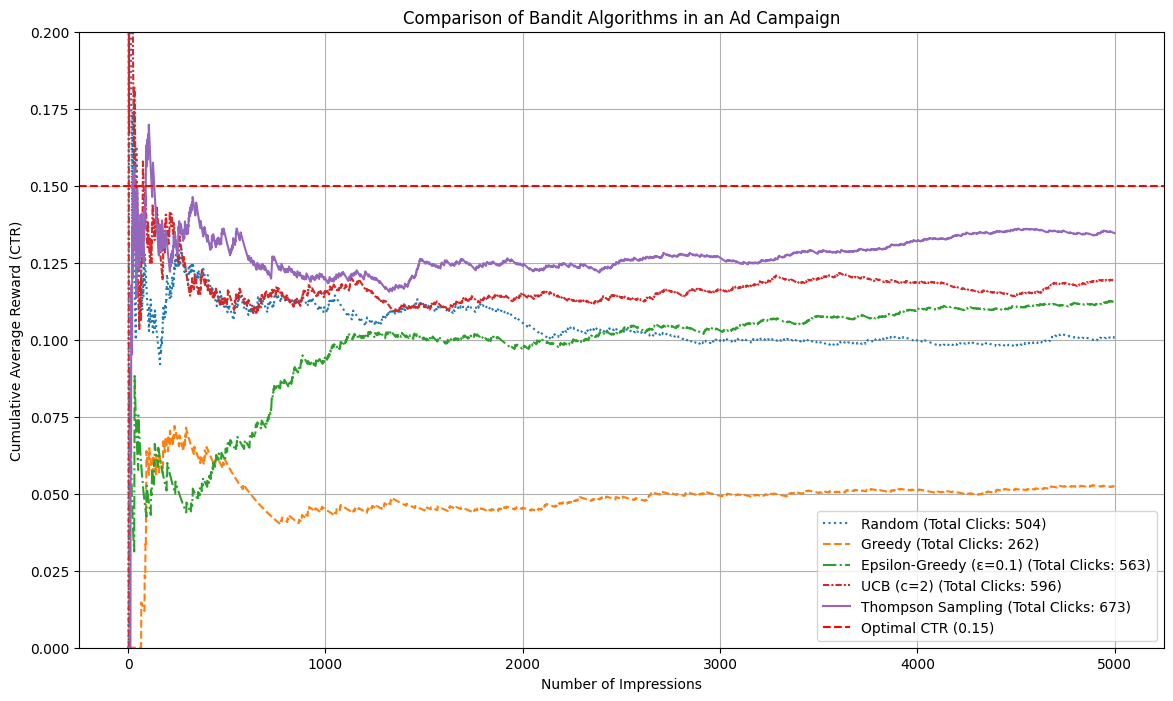

In [319]:
import matplotlib.pyplot as plt
import numpy as np

# --- Simulation Parameters ---
num_impressions = 5000
true_ctrs = [0.05, 0.12, 0.08, 0.15, 0.11] # Ad with index 3 is best

# --- Agent and Environment Initialization ---
# Assuming the agent and environment classes from previous listings are defined
env = AdCampaignEnvironment(ad_probabilities=true_ctrs)
agents = {
    "Random": RandomAgent(num_ads=env.num_ads),
    "Greedy": GreedyAgent(num_ads=env.num_ads),
    "Epsilon-Greedy (ε=0.1)": EpsilonGreedyAgent(num_ads=env.num_ads, epsilon=0.1),
    "UCB (c=2)": UCBAgent(num_ads=env.num_ads, c=2),
    "Thompson Sampling": ThompsonSamplingAgent(num_ads=env.num_ads)
}

# --- Data Tracking ---
rewards = {name: [] for name in agents.keys()}
environments = {name: AdCampaignEnvironment(ad_probabilities=true_ctrs) for name in agents.keys()}

# --- Run Simulation for Each Agent ---
for name, agent in agents.items():
    env = environments[name]
    for i in range(num_impressions):
        chosen_ad = agent.choose_action()
        reward = env.pull_arm(chosen_ad)
        if name != "Random":
            agent.update(chosen_ad, reward)
        else:
            agent.arm_counts[chosen_ad] +=1
        rewards[name].append(reward)

# --- Analysis and Plotting ---
plt.figure(figsize=(14, 8))

# Define line styles for black and white printing
linestyles = {
    "Random": "dotted", # ':'
    "Greedy": "dashed", # '--'
    "Epsilon-Greedy (ε=0.1)": "dashdot", # '-.'
    "UCB (c=2)": (0, (3, 1, 1, 1)), # A custom dash-dot-dot style
    "Thompson Sampling": "solid" # '-'
}

final_results = {}
for name, reward_list in rewards.items():
    total_reward = sum(reward_list)
    avg_reward = total_reward / num_impressions
    final_results[name] = (total_reward, avg_reward)
    
    # Calculate running average reward for plotting
    running_average = np.cumsum(reward_list) / (np.arange(num_impressions) + 1)
    # Add the linestyle parameter to the plot call
    plt.plot(running_average, 
             label=f"{name} (Total Clicks: {total_reward})", 
             linestyle=linestyles[name])

# Print final results for clarity
print("--- Final Ad Campaign Results ---")
for name, results in sorted(final_results.items(), key=lambda item: item[1][0], reverse=True):
    print(f"{name:<25} | Total Clicks: {results[0]:<5} | Final CTR: {results[1]:.4f}")
print("-" * 50)

# Add plot details
plt.axhline(y=max(true_ctrs), color='r', linestyle='--', label=f"Optimal CTR ({max(true_ctrs)})")
plt.title("Comparison of Bandit Algorithms in an Ad Campaign")
plt.xlabel("Number of Impressions")
plt.ylabel("Cumulative Average Reward (CTR)")
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0, 0.2)
plt.show()

## Comparing with Regret

Random                    | Total Regret: 24.54
Greedy                    | Total Regret: 49.74
Epsilon-Greedy (ε=0.1)    | Total Regret: 18.00
UCB (c=2)                 | Total Regret: 19.91
Thompson Sampling         | Total Regret: 14.66


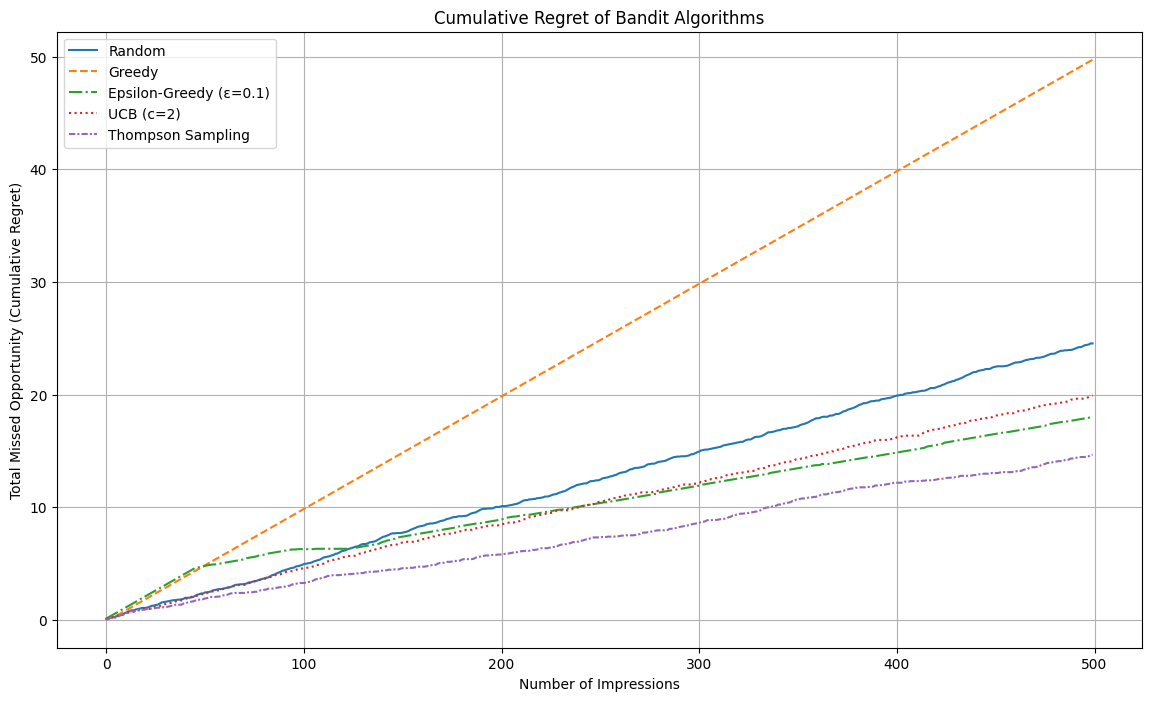

In [320]:
import matplotlib.pyplot as plt
import numpy as np

# --- Re-use Parameters and Agent Definitions from previous listings ---

# --- Simulation Parameters ---
num_impressions = 500
true_ctrs = [0.05, 0.12, 0.08, 0.15, 0.11]  # Ad with index 3 is best at 0.15
optimal_ctr = max(true_ctrs)

# --- Initialization ---
agents = {
    "Random": RandomAgent(num_ads=len(true_ctrs)),
    "Greedy": GreedyAgent(num_ads=len(true_ctrs)),
    "Epsilon-Greedy (ε=0.1)": EpsilonGreedyAgent(num_ads=len(true_ctrs), epsilon=0.1),
    "UCB (c=2)": UCBAgent(num_ads=len(true_ctrs), c=2),
    "Thompson Sampling": ThompsonSamplingAgent(num_ads=len(true_ctrs))
}

# --- Data Tracking for Regret ---
cumulative_regret = {name: [0] * num_impressions for name in agents.keys()}
environments = {name: AdCampaignEnvironment(ad_probabilities=true_ctrs) for name in agents.keys()}

# --- Run Simulation for Each Agent ---
for name, agent in agents.items():
    env = environments[name]
    for i in range(num_impressions):
        chosen_ad = agent.choose_action()
        reward = env.pull_arm(chosen_ad)

        if name != "Random":
            agent.update(chosen_ad, reward)
        else:
            agent.arm_counts[chosen_ad] += 1

        step_regret = optimal_ctr - true_ctrs[chosen_ad]
        cumulative_regret[name][i] = (
            step_regret if i == 0 else cumulative_regret[name][i - 1] + step_regret
        )

# --- Analysis and Plotting ---
plt.figure(figsize=(14, 8))

# Different line styles to make lines distinct
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # last is dash-dot-dot

for idx, (name, regret_list) in enumerate(cumulative_regret.items()):
    plt.plot(
        regret_list,
        label=f"{name}",
        linestyle=line_styles[idx % len(line_styles)]  # cycle through styles
    )
    print(f"{name:<25} | Total Regret: {regret_list[-1]:.2f}")

# Add plot details
plt.title("Cumulative Regret of Bandit Algorithms")
plt.xlabel("Number of Impressions")
plt.ylabel("Total Missed Opportunity (Cumulative Regret)")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
